<h1 align=center><font size = 8>Situación Covid-19 en Galicia</font></h1>

El propósito de este notebook es capturar de la <a href="https://coronavirus.sergas.gal/datos/#/gl-ES/undefined">web del Sergas</a> los datos actualizados de la situación de Galicia frente al Covid-19, y posteriormente realizar algunos análisis básicos, guardando los resultados en directorios.

Para los cálculos basados en el número de habitantes se emplea un fichero csv obteniendo mediante otro notebook, llamado _Población Areas_ y también disponible en el repositorio de GitHub. Se debe de tener en cuenta que en este análisis se trabaja con áreas sanitarias y no con ayuntamientos. Pese a que todos los nombres de las áreas sanitarias coinciden también con nombres de ayuntamientos, en ellas se encuentran englobadas otras comarcas y ayuntamientos limítrofes y próximas.

In [1]:
from classes.covid19galicia import covid19galicia
import pandas as pd

# 1. Importación de datos

Creamos la clase que maneja los datos de la web del Sergas e importamos solamente aquellos que son necesarios para las futuras gráficas.

In [2]:
galicia = covid19galicia()
casos_activos = galicia.getCifrasTotais()
infectados_fecha = galicia.getInfeccionesPorFecha()
camas = galicia.getOcupacionCamas()
fallecidos = galicia.getActivosCuradosFallecidos()
inc14 = galicia.getIncidenciaConcello()

Ultima actualización: 2021-05-26


Podemos visualizar los datos del último día:

In [3]:
total = galicia.getCifrasTotais()
print('En las últimas 24h hubo {} casos en Galicia'.format(total['Casos_Confirmados_PCR_Ultimas24h'].sum()))
total

En las últimas 24h hubo 112 casos en Galicia


,Fecha,Area_Sanitaria,Casos_Totais,Casos_Confirmados_PCR_Ultimas24h,Pacientes_Sin_Alta,Pacientes_Con_Alta,Camas_Ocupadas_HOS,Camas_Ocupadas_UCI,Probas_Realizadas_PCR,Probas_Realizadas_Non_PCR,Exitus
0,2021-05-26,A Coruña,30326,10,461,29288,26,4,497883,255203,591
1,2021-05-26,Ferrol,8567,3,75,8269,4,3,142744,45235,217
2,2021-05-26,Lugo,12806,11,222,12364,11,2,241600,111422,215
3,2021-05-26,Ourense,15667,8,191,15059,6,6,253735,133786,418
4,2021-05-26,Pontevedra,14214,19,310,13727,11,4,233965,119016,178
5,2021-05-26,Santiago,19889,23,439,19100,17,3,358457,180655,362
6,2021-05-26,Vigo,24903,38,722,23755,21,6,501019,119476,434


# 2. Análisis

## 2.1. Casos activos - Total por área sanitaria

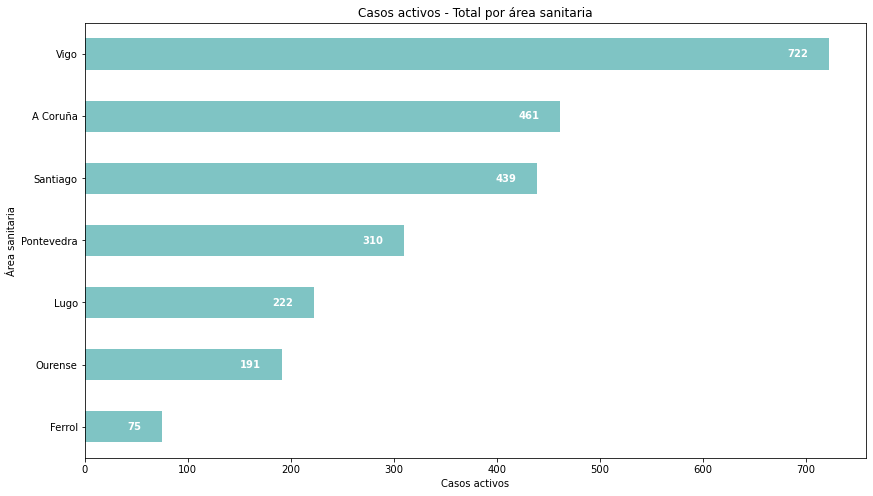

In [4]:
galicia.plotCasosActivos(casos_activos, cienmil=False)

## 2.2. Casos activos - Porcentaje por área sanitaria

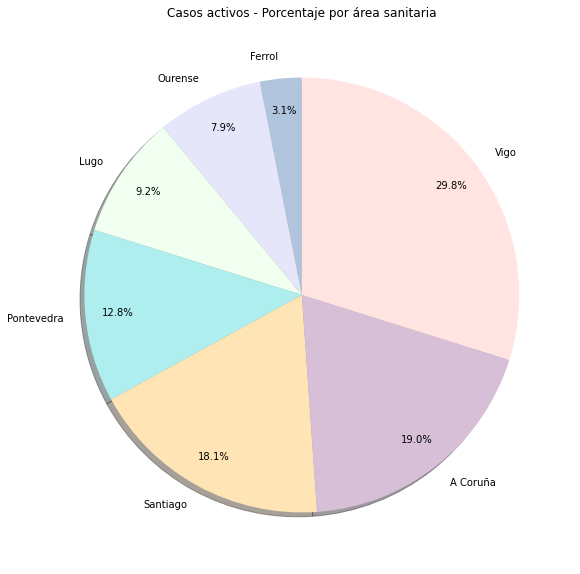

In [5]:
galicia.plotPorcentajeAreas(casos_activos)

## 2.3. Positivos

### 2.3.1. Evolución positivos acumulados últimos 7 días

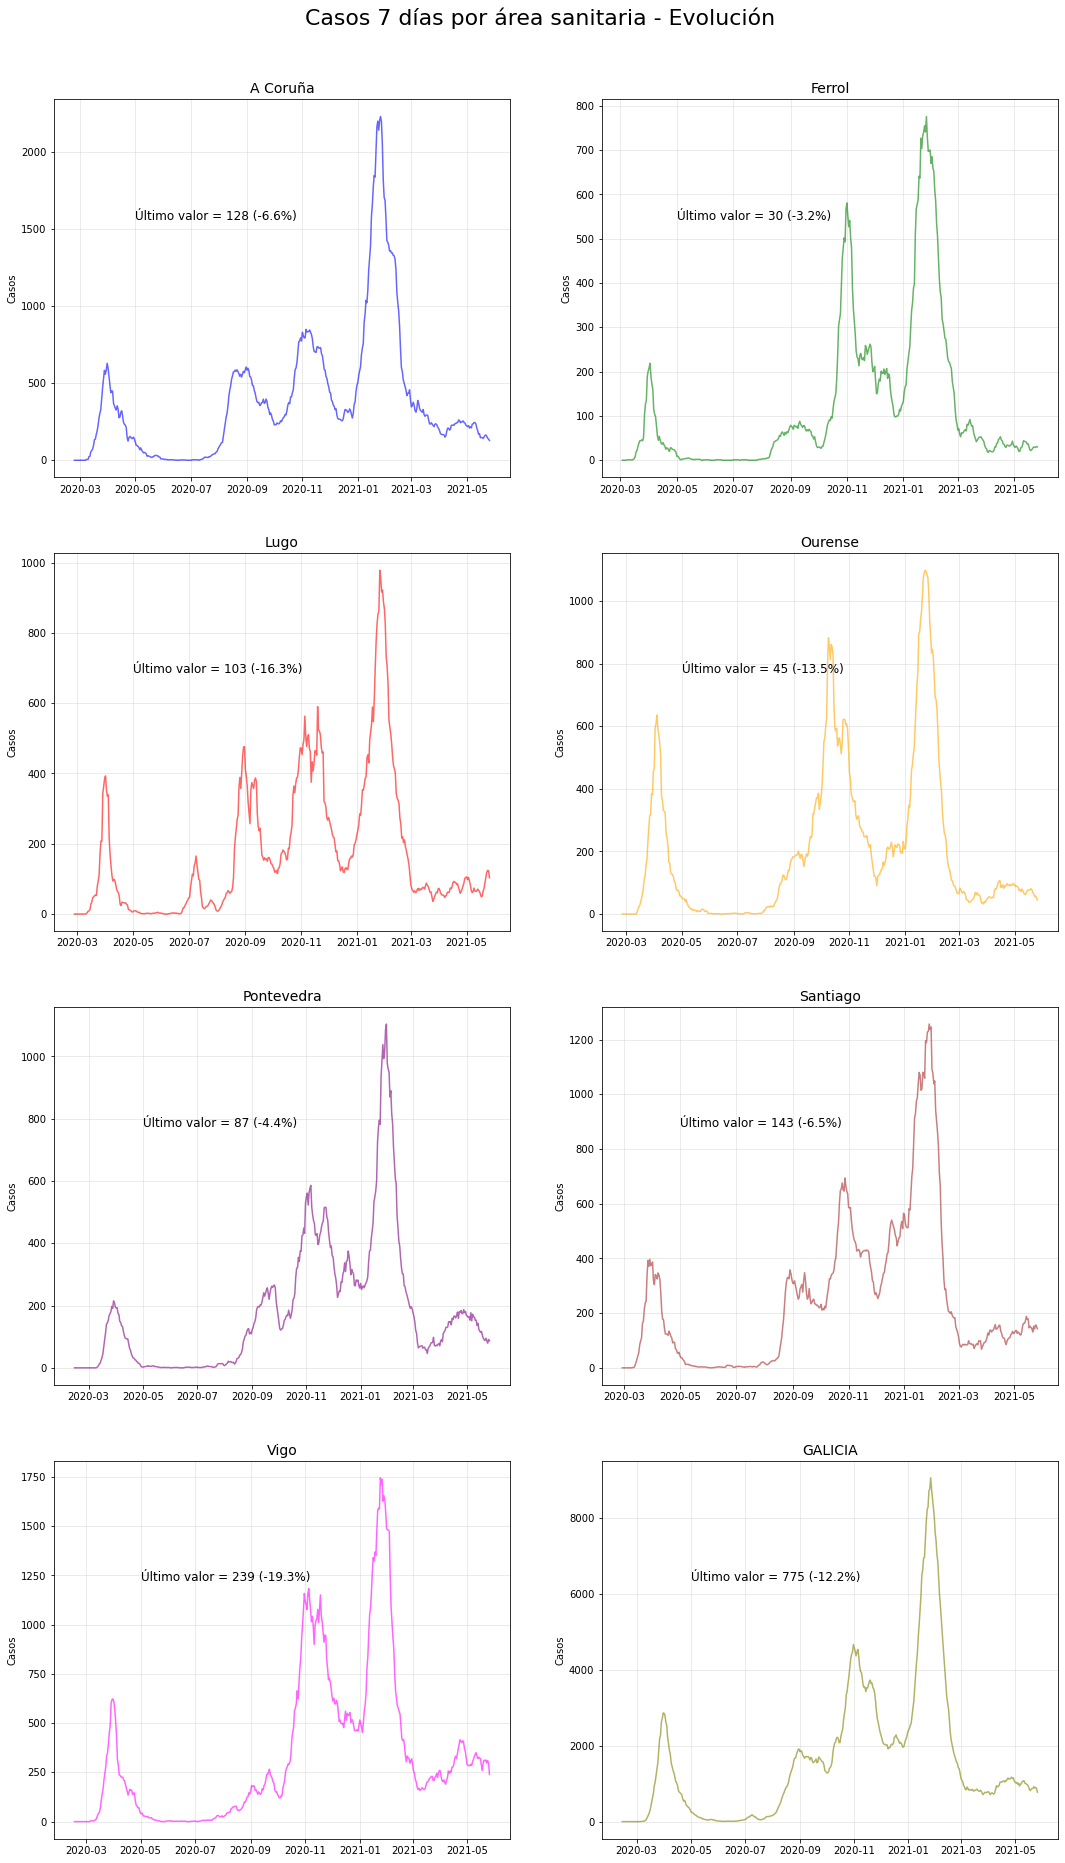

In [6]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=7)

### 2.3.2. Comparativo positivos acumulados últimos 7 días

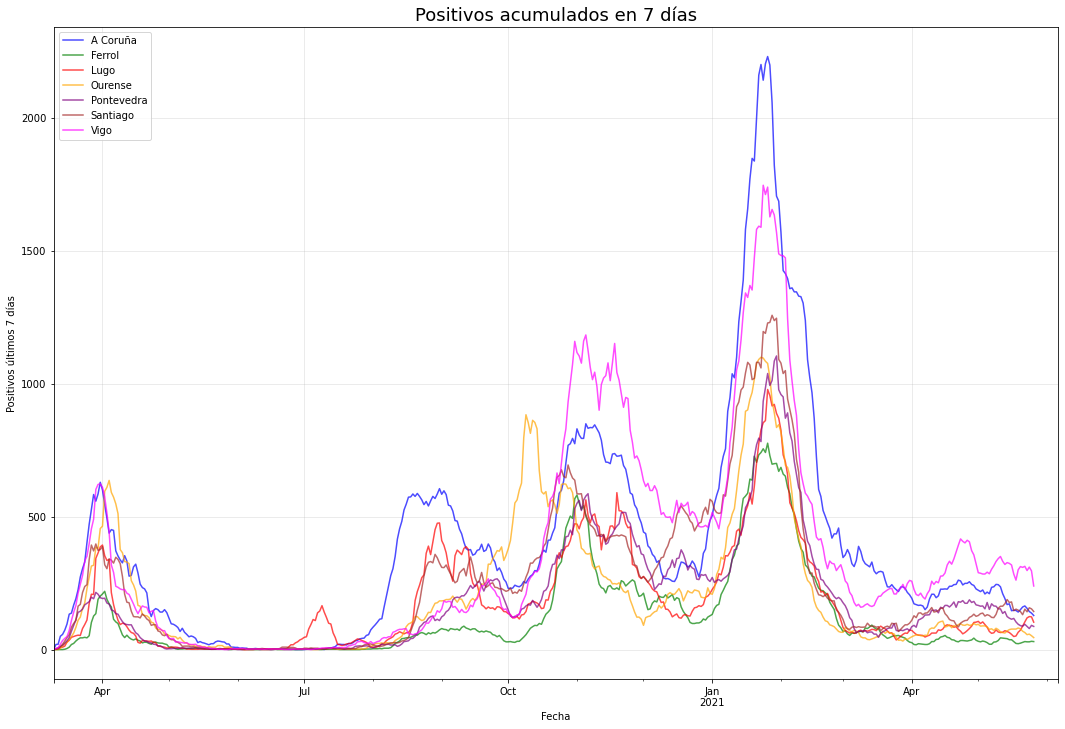

In [7]:
galicia.plotCombinado(infectados_fecha)

### 2.3.3. Principales ciudades - Incidencia 14 días / 100.000 habitantes

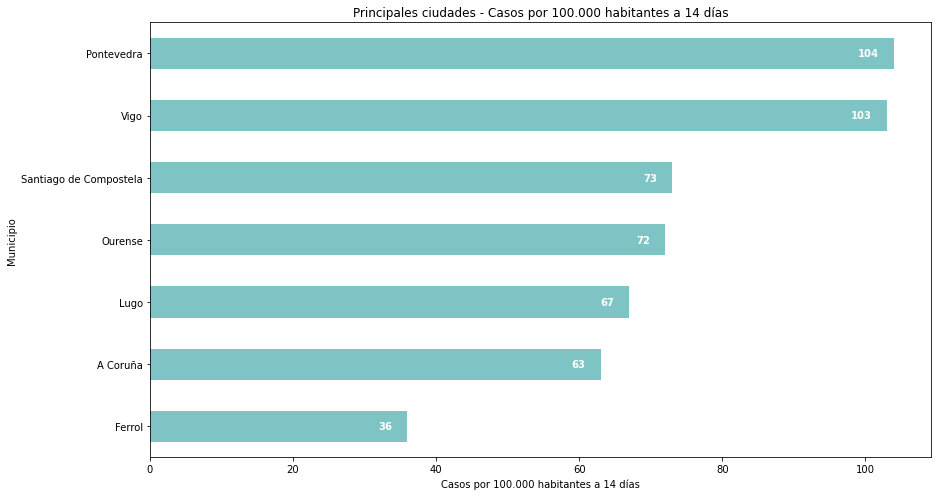

In [8]:
galicia.plotIncidenciaAcumulada(inc14, 'ciudades')

### 2.3.4. Top 10 municipios con mayor incidencia 14 días / 100.000 habitantes

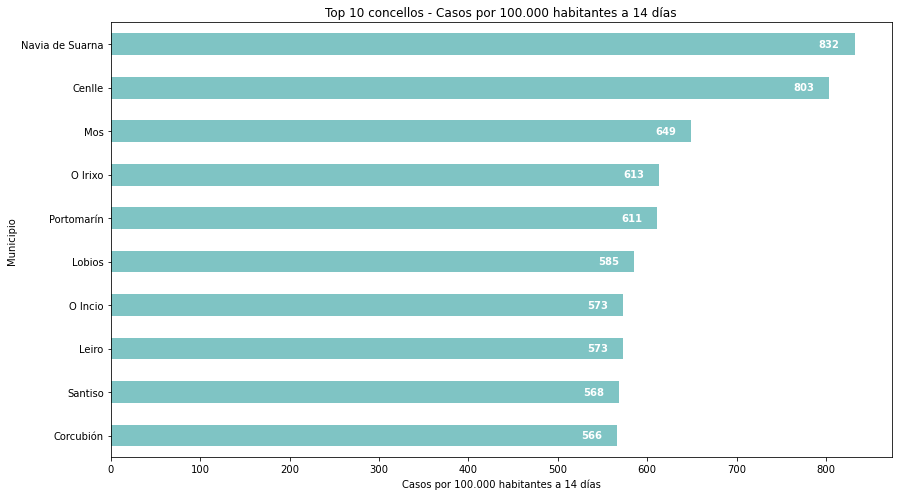

In [9]:
galicia.plotIncidenciaAcumulada(inc14, 'top10')

## 2.4. Evolución PCR acumuladas 7 días

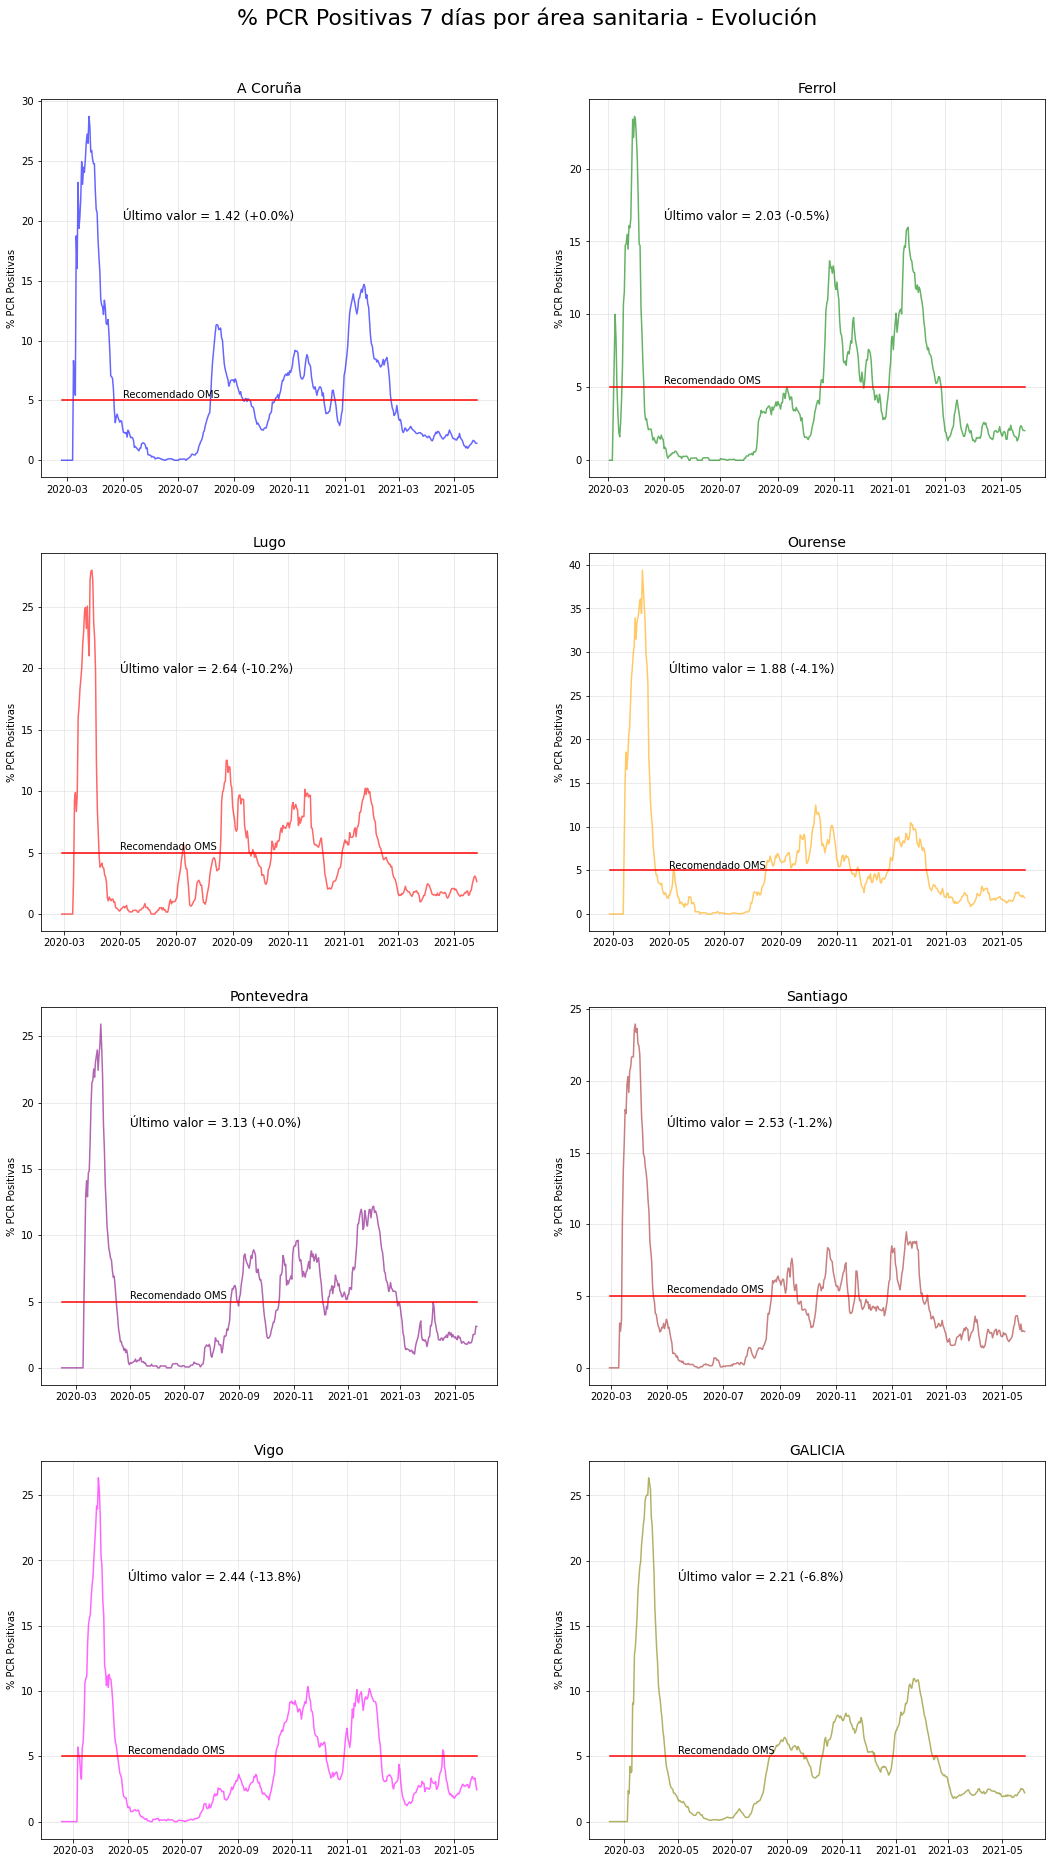

In [10]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=7)

## 2.5. Tendencias

### 2.5.1. Clara tendencia en aumento

In [11]:
inc14 = inc14[inc14['Tendencia'].notna()]
inc14 = inc14[inc14['Casos7'] != inc14['Casos']]
inc14.sort_values('Tendencia', ascending=False)
incrementos = list(inc14['Municipio'][inc14['Tendencia'] > 10])
incrementos.sort()
print(*incrementos, sep=', ')

Arteixo, Bueu, Cambre, Cee, Ferrol, Gondomar, Lobios, Moraña, Narón, Nigrán, O Porriño, Oleiros, Oroso, Ponte Caldelas, Pontevedra, Redondela, Rianxo, Viveiro, Xove


### 2.5.2. Clara tendencia en descenso

In [12]:
descensos = list(inc14['Municipio'][inc14['Tendencia'] < -10])
descensos.sort()
print(*descensos, sep=', ')

A Baña, A Cañiza, A Coruña, A Guarda, A Peroxa, A Pobra do Caramiñal, Agolada, Ames, Arbo, Baiona, Boiro, Cabana de Bergantiños, Cambados, Cerceda, Covelo, Crecente, Culleredo, Cuntis, Fornelos de Montes, Guitiriz, Lalín, Leiro, Lourenzá, Lugo, Maceda, Malpica de Bergantiños, Melide, Moaña, Mondariz, Muxía, O Incio, O Pereiro de Aguiar, Oia, Ordes, Ourense, Padrón, Pantón, Pol, Ponteareas, Portas, Ribadavia, Salceda de Caselas, San Cristovo de Cea, Santiso, Sarria, Tui, Vila de Cruces, Vilagarcía de Arousa, Vilalba


## 2.6. Ocupación actual de camas

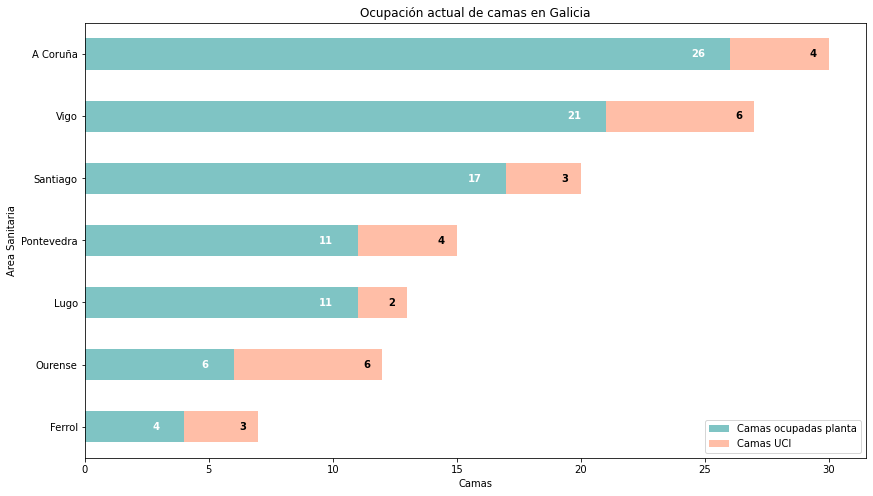

In [13]:
galicia.plotOcupacionCamas(camas)

## 2.7. Fallecidos

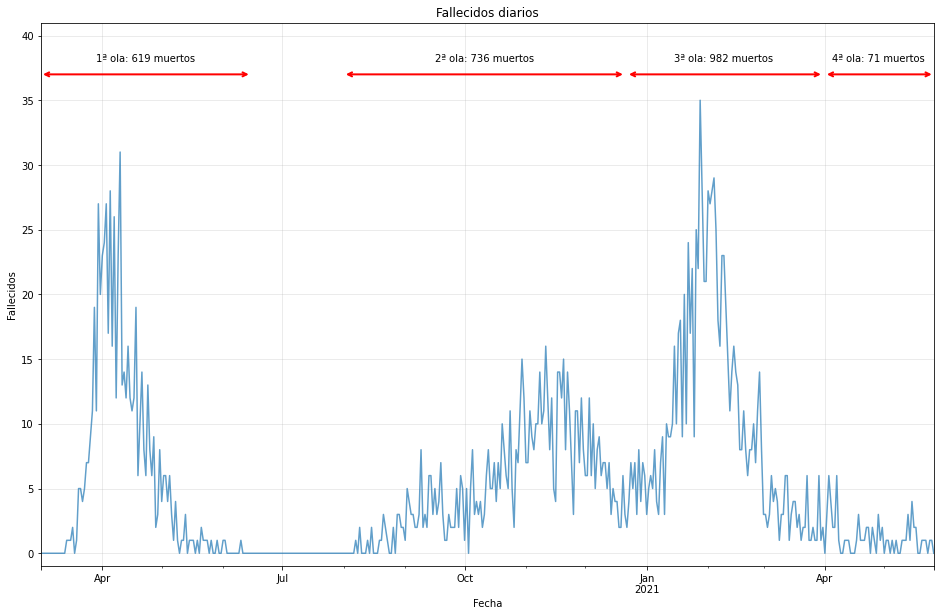

In [14]:
galicia.plotFallecidos(fallecidos)